In [1]:
import glob
import re

import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils import Graph

PATH = '/Users/davidc-local/Neutrinos/LArCADe/SimLArCADe/py/gas-townsend/2PSI/'

field_strength = np.array([3000,5000,7500,9000,10000,20000,30000,50000,75000,90000]) # V / cm
density = 1.15e19 # cm^-3
Td = 1e-17 # 1 Td = 10^-17 V * cm^2

reducedfield_v = (field_strength / density) / Td

In [2]:
plt.rcParams.update({'font.size': 16})

In [3]:
from scipy.optimize import curve_fit

def gauss(x,mu,sigma,A):
    norm = A/(np.sqrt(2*np.pi)*sigma)
    exp  = np.exp(-((x-mu)**2)/(2*sigma*sigma))
    return norm * exp

def FitGauss(vals):
    variance = np.std(vals)
    mean = np.mean(vals)
    BINS = np.linspace(mean-2*variance,mean+2*variance,21)
    binned,edges = np.histogram(vals,bins=BINS)
    bcenters = 0.5*(edges[1:]+edges[:-1])
    guess = [mean,variance/2.,np.max(binned)]
    try:
        popt,popv = curve_fit(gauss,bcenters,binned,p0=guess)
        return popt[0],popt[1],popt[2],1
    except:
        return mean,variance,1,0
    #pope = np.sqrt(np.diag(popv))

In [4]:
gardiff = open('lxcat/gar_townsend.csv','r')
measurements_v = []
EN_v = []
diff_v = []
for line in gardiff:
    words = line.split()
    if (len(words) < 2): 
        if ( (len(EN_v) == len(diff_v)) and (len(EN_v) > 0) ):
            measurements_v.append([EN_v,diff_v])
        EN_v = []
        diff_v = []
    else:
        EN_v.append(float(words[0]))
        diff_v.append(float(words[1]))

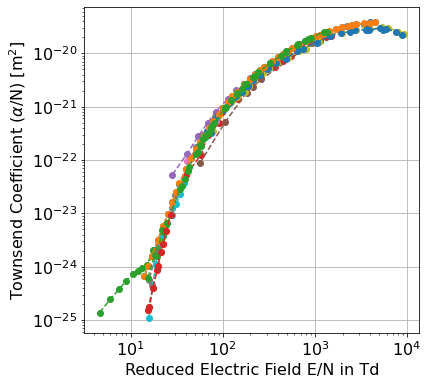

In [5]:
fig = plt.figure(figsize=(6,6))
for measurement in measurements_v:
    plt.plot(measurement[0],measurement[1],'o--')
plt.xlabel('Reduced Electric Field E/N in Td')
plt.ylabel(r'Townsend Coefficient ($\alpha$/N) [m${}^{2}$]')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.show()

The below two cells load the necessary files and compute the diffusion coefficients. At various fields, $100$ electrons were spawned and allowed to propagate for $10$ ns.

In [6]:
file_tree = {}

for field in field_strength:
    for file in glob.glob(f'{PATH}/{field}/*.txt'):
        key = int(re.search(r'(\d*)(?:V)', file).group(1))
        if (key in file_tree):
            file_tree[key].append(file)
        else:
            file_tree[key] = [file]

The below shows the estimation process of the diffusion coefficients: the variance of each coordinate of the electrons in the cloud is plotted as a function of time. The diffusion coefficients are the slopes of these lines.

In [14]:
ctr = 0
reduced_field_v = []
reduced_alpha_v = []

for key, value in sorted(file_tree.items()):

 
    group = Graph(value)
    
    print ('field_strength : ',field_strength[ctr])
    
    # keep track of number of ionizations produced per electron
    ionization_list = []
    # keep track of distance traveled
    distance_list = []
    # loop through number of simulated electrons
    for k in range(group.n):
        #ionization_list.append(group.ionized[k][-1])
        ionization_list.append( 2**((group.ionized[k][-1])) )
        distance_list.append(group.x[k][-1])
    #ionization_list = np.array(ionization_list) + 1
    distance_list = np.array(distance_list)
    ioni_per_dist_list = ionization_list / distance_list
    mean_ioni = np.mean(ioni_per_dist_list)
    #ionizations_per_dist_mean_v.append(mean_ioni)
    print (r'mean ionization / unit distance [$\mu$m] : %g'%(mean_ioni))
    # townsend coeff. from:
    # https://en.wikipedia.org/wiki/Townsend_discharge
    # but to get the reduced value divide by density
    alpha_v = np.log(ionization_list) / distance_list
    # 2 Atm = 1520 Torr = 1.520 meters
    alpha_red = np.mean(alpha_v) / 1e-6 / (density * 1e6) # (1e-6 is because distance stored in um)
    print (r'mean alpha : %g'%alpha_red)
    reduced_field_v.append(reducedfield_v[ctr])
    reduced_alpha_v.append(alpha_red)
    
    ctr += 1

field_strength :  3000
mean ionization / unit distance [$\mu$m] : 0.00772137
mean alpha : 3.95796e-23
field_strength :  5000
mean ionization / unit distance [$\mu$m] : 0.00917012
mean alpha : 2.04178e-22
field_strength :  7500
mean ionization / unit distance [$\mu$m] : 0.0549452
mean alpha : 5.08239e-22
field_strength :  9000
mean ionization / unit distance [$\mu$m] : 0.444637
mean alpha : 7.62407e-22
field_strength :  10000
mean ionization / unit distance [$\mu$m] : 8.27622
mean alpha : 1.0118e-21
field_strength :  20000
mean ionization / unit distance [$\mu$m] : 8.55001e+15
mean alpha : 3.29049e-21
field_strength :  30000
mean ionization / unit distance [$\mu$m] : 3.49381e+45
mean alpha : 5.99866e-21
field_strength :  50000
mean ionization / unit distance [$\mu$m] : 4.2645e+155
mean alpha : 1.18868e-20
field_strength :  75000
mean ionization / unit distance [$\mu$m] : 6.09505e+41
mean alpha : 2.01126e-20
field_strength :  90000
mean ionization / unit distance [$\mu$m] : 7.80074e+75
m

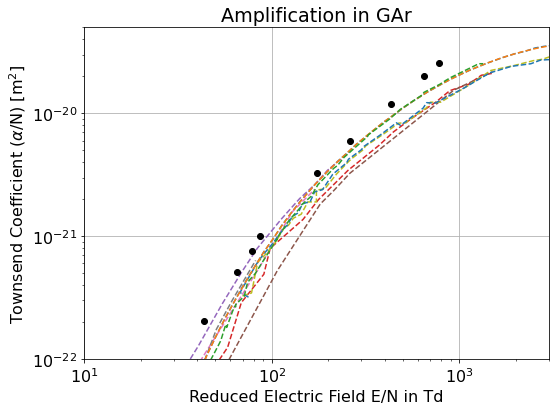

In [18]:
fig = plt.figure(figsize=(8,6))
for measurement in measurements_v:
    plt.plot(measurement[0],measurement[1],'--')
plt.plot(reduced_field_v,reduced_alpha_v,'ko')
plt.xlabel('Reduced Electric Field E/N in Td')
plt.ylabel(r'Townsend Coefficient ($\alpha$/N) [m${}^{2}$]')
plt.title('Amplification in GAr')
plt.xscale('log')
plt.xlim([10,3000])
plt.ylim([1e-22,5e-20])
plt.yscale('log')
plt.grid()
plt.tight_layout()
plt.savefig('plots/gar-townsend.pdf',dpi=250)
plt.show()